In [1]:
!pip install torch matplotlib rich --quiet
!pip install numpy --force-reinstall --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 88.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cu

In [2]:
import os, sys, subprocess

import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:

print("cwd:", os.getcwd())

if not os.path.isdir("CooperativeNNQST"):
    subprocess.run(["git", "clone", "https://github.com/kyongmini/CooperativeNNQST.git"], check=True)
else:
    subprocess.run(["git", "-C", "CooperativeNNQST", "pull", "-q"], check=True)

src_path = os.path.abspath("CooperativeNNQST/2qubit/src")
print("adding to sys.path:", src_path)
if src_path not in sys.path:
    sys.path.insert(0, src_path)

cwd: /content
adding to sys.path: /content/CooperativeNNQST/2qubit/src


In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from mystyle import my_style, print_banner, print_text
from models import WavefunctionRBM
from generation_cc import generation_cc
from qst_definition import fidelity, set_seed
from measurement import MeasurementRecord_from_cc
from training_amplitude import train_amplitude_network
from training_phase import train_phase_network
from visualization import plot_with_fill, qdisplay, qanimation

In [5]:
target_state = np.array([1/np.sqrt(2), 0, 0, 1j/np.sqrt(2)], dtype=np.complex64)
target_rho = np.outer(target_state, np.conjugate(target_state))

print(generation_cc(target_state))

{
    "ZZ": {"HH": 2500, "HV": 0, "VH": 0, "VV": 2500},
    "ZX": {"HD": 1250, "HA": 1250, "VD": 1250, "VA": 1250},
    "ZY": {"HR": 1250, "HL": 1250, "VR": 1250, "VL": 1250},
    "XZ": {"DH": 1250, "DV": 1250, "AH": 1250, "AV": 1250},
    "XX": {"DD": 1250, "DA": 1250, "AD": 1250, "AA": 1250},
    "XY": {"DR": 2500, "DL": 0, "AR": 0, "AL": 2500},
    "YZ": {"RH": 1250, "RV": 1250, "LH": 1250, "LV": 1250},
    "YX": {"RD": 2500, "RA": 0, "LD": 0, "LA": 2500},
    "YY": {"RR": 1250, "RL": 1250, "LR": 1250, "LL": 1250}
}


In [6]:
if __name__ == "__main__":
    # Setting Environment

    set_seed(25) #if you do not want seed, remove this code
    my_style(fontsize=12)
    os.makedirs("figures", exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print_banner(f"Using device: {device}")

    # Target state you want
    n_qubits = 2

    # Experimental Data (Simulation data : generation_cc funciton)
    experimental_counts = {
      "ZZ": {"HH": 2500, "HV": 0, "VH": 0, "VV": 2500},
      "ZX": {"HD": 1250, "HA": 1250, "VD": 1250, "VA": 1250},
      "ZY": {"HR": 1250, "HL": 1250, "VR": 1250, "VL": 1250},
      "XZ": {"DH": 1250, "DV": 1250, "AH": 1250, "AV": 1250},
      "XX": {"DD": 1250, "DA": 1250, "AD": 1250, "AA": 1250},
      "XY": {"DR": 2500, "DL": 0, "AR": 0, "AL": 2500},
      "YZ": {"RH": 1250, "RV": 1250, "LH": 1250, "LV": 1250},
      "YX": {"RD": 2500, "RA": 0, "LD": 0, "LA": 2500},
      "YY": {"RR": 1250, "RL": 1250, "LR": 1250, "LL": 1250}
}

    all_measurements = MeasurementRecord_from_cc(experimental_counts)
    z_measurements = [m for m in all_measurements if m.Pauli_basis == "ZZ"]

    # initialize the model
    model = WavefunctionRBM(n_visible=n_qubits, n_hidden_amp=4, n_hidden_phase=4).to(device)

    # amplitude training
    amp_dm_log, amp_loss_log, amp_fid_log = train_amplitude_network(
        wf_rbm=model,
        z_measurements=z_measurements,
        n_epochs=200,
        lr=0.01,
        target_rho=target_rho,
        k_cd=30,
        batch_size=1024
    )

    # phase training
    phase_dm_log, phase_loss_log, phase_fid_log = train_phase_network(
        wf_rbm=model,
        measurements=all_measurements,
        n_epochs=300,
        lr=0.01,
        target_rho=target_rho,
        n_mcmc=1024,
        k_steps=10,
        burn_in=50,
        batch_size=1024
    )

─────────────────────────────────────────────────── [Seed : 25] ───────────────────────────────────────────────────

──────────────────────────────────────────────── Using device: cpu ────────────────────────────────────────────────

───────────────────────────────────────── Reading your coincidence count. ─────────────────────────────────────────

──────────────────────────────────────── Total coincidence counts : 45000 ─────────────────────────────────────────

──────────────────────────────────────────────── Amplitude Network ────────────────────────────────────────────────

───────────────────── Amplitude Training : Epoch 20/200 | CD loss: -0.2730 | Fidelity: 0.1455 ─────────────────────

───────────────────── Amplitude Training : Epoch 40/200 | CD loss: -0.1133 | Fidelity: 0.2357 ─────────────────────

───────────────────── Amplitude Training : Epoch 60/200 | CD loss: -0.0586 | Fidelity: 0.2444 ─────────────────────

───────────────────── Amplitude Training : Epoch 80/200 | CD loss: -0.0334 | Fidelity: 0.2473 ─────────────────────

──────────────────── Amplitude Training : Epoch 100/200 | CD loss: -0.0319 | Fidelity: 0.2487 ─────────────────────

──────────────────── Amplitude Training : Epoch 120/200 | CD loss: -0.0247 | Fidelity: 0.2495 ─────────────────────

──────────────────── Amplitude Training : Epoch 140/200 | CD loss: -0.0211 | Fidelity: 0.2500 ─────────────────────

──────────────────── Amplitude Training : Epoch 160/200 | CD loss: -0.0110 | Fidelity: 0.2503 ─────────────────────

──────────────────── Amplitude Training : Epoch 180/200 | CD loss: -0.0146 | Fidelity: 0.2505 ─────────────────────

──────────────────── Amplitude Training : Epoch 200/200 | CD loss: -0.0177 | Fidelity: 0.2507 ─────────────────────

──────────────────────────────── Cooperative Phase Network with analytic gradient ─────────────────────────────────

─────────────────────── Phase Training : Epoch 20/300 | Loss: -0.153446 | Fidelity: 0.9387 ────────────────────────

─────────────────────── Phase Training : Epoch 40/300 | Loss: -0.161799 | Fidelity: 0.9759 ────────────────────────

─────────────────────── Phase Training : Epoch 60/300 | Loss: -0.161348 | Fidelity: 0.9962 ────────────────────────

─────────────────────── Phase Training : Epoch 80/300 | Loss: -0.160682 | Fidelity: 0.9963 ────────────────────────

─────────────────────── Phase Training : Epoch 100/300 | Loss: -0.159184 | Fidelity: 0.9960 ───────────────────────

─────────────────────── Phase Training : Epoch 120/300 | Loss: -0.159365 | Fidelity: 0.9962 ───────────────────────

─────────────────────── Phase Training : Epoch 140/300 | Loss: -0.157185 | Fidelity: 0.9963 ───────────────────────

─────────────────────── Phase Training : Epoch 160/300 | Loss: -0.159619 | Fidelity: 0.9964 ───────────────────────

─────────────────────── Phase Training : Epoch 180/300 | Loss: -0.158081 | Fidelity: 0.9964 ───────────────────────

─────────────────────── Phase Training : Epoch 200/300 | Loss: -0.160366 | Fidelity: 0.9964 ───────────────────────

─────────────────────── Phase Training : Epoch 220/300 | Loss: -0.156474 | Fidelity: 0.9960 ───────────────────────

─────────────────────── Phase Training : Epoch 240/300 | Loss: -0.159467 | Fidelity: 0.9963 ───────────────────────

─────────────────────── Phase Training : Epoch 260/300 | Loss: -0.158360 | Fidelity: 0.9964 ───────────────────────

─────────────────────── Phase Training : Epoch 280/300 | Loss: -0.160540 | Fidelity: 0.9964 ───────────────────────

─────────────────────── Phase Training : Epoch 300/300 | Loss: -0.160264 | Fidelity: 0.9963 ───────────────────────

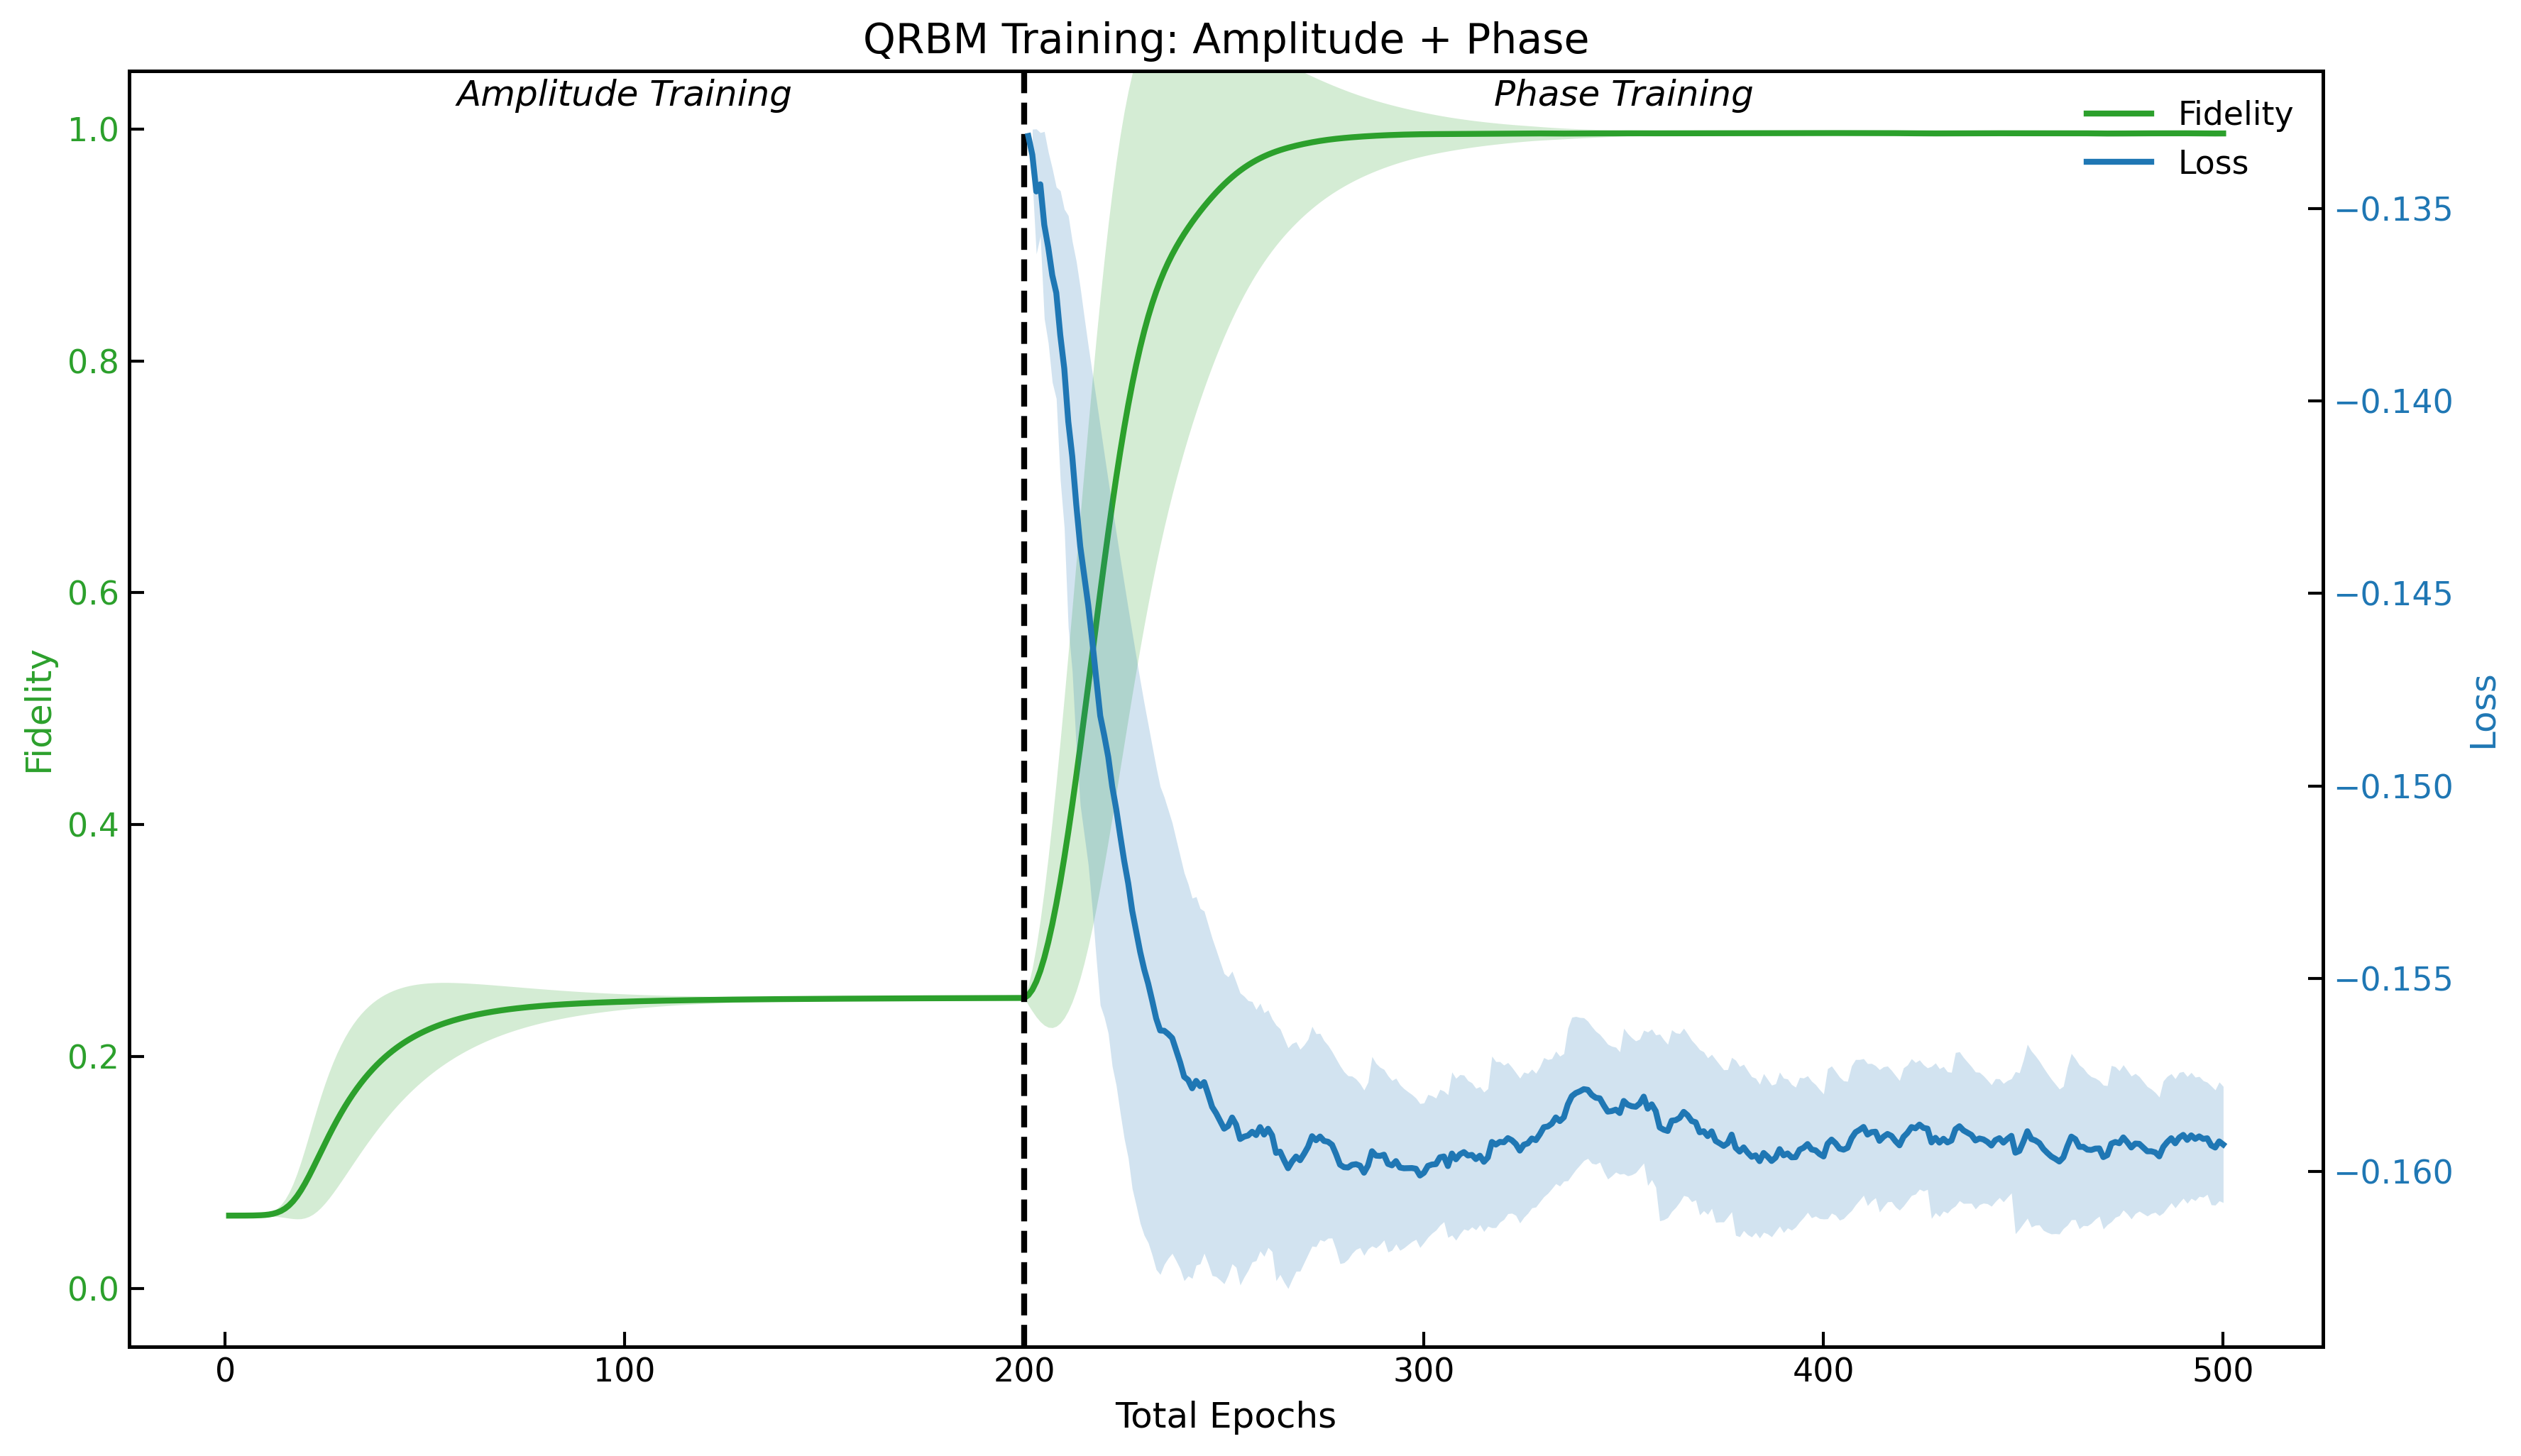

In [7]:
# loss and fidelity graph
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()
total_epochs = np.arange(1, len(amp_fid_log + phase_fid_log) + 1)
combined_fid = amp_fid_log + phase_fid_log
combined_loss = [np.nan] * len(amp_loss_log) + phase_loss_log

plot_with_fill(ax1, total_epochs, combined_fid, label="Fidelity", color="tab:green")
ax1.set_ylabel("Fidelity", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:green")
ax1.set_ylim(-0.05, 1.05)

plot_with_fill(ax2, total_epochs, combined_loss, label="Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax1.set_xlabel("Total Epochs")
ax1.axvline(x=len(amp_loss_log), color='black', linestyle='--')
ax1.set_title("QRBM Training: Amplitude + Phase")
ax1.text(len(amp_loss_log) / 2, 1.02, 'Amplitude Training', ha='center', style='italic')
ax1.text(len(amp_loss_log) + len(phase_loss_log) / 2, 1.02, 'Phase Training', ha='center', style='italic')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.savefig("figures/training_dynamics_combined.png")
plt.show()

───────────────────────────────────────  Final Fidelity vs Target: 0.996339 ───────────────────────────────────────

/content/CooperativeNNQST/2qubit/src/visualization.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2.0)


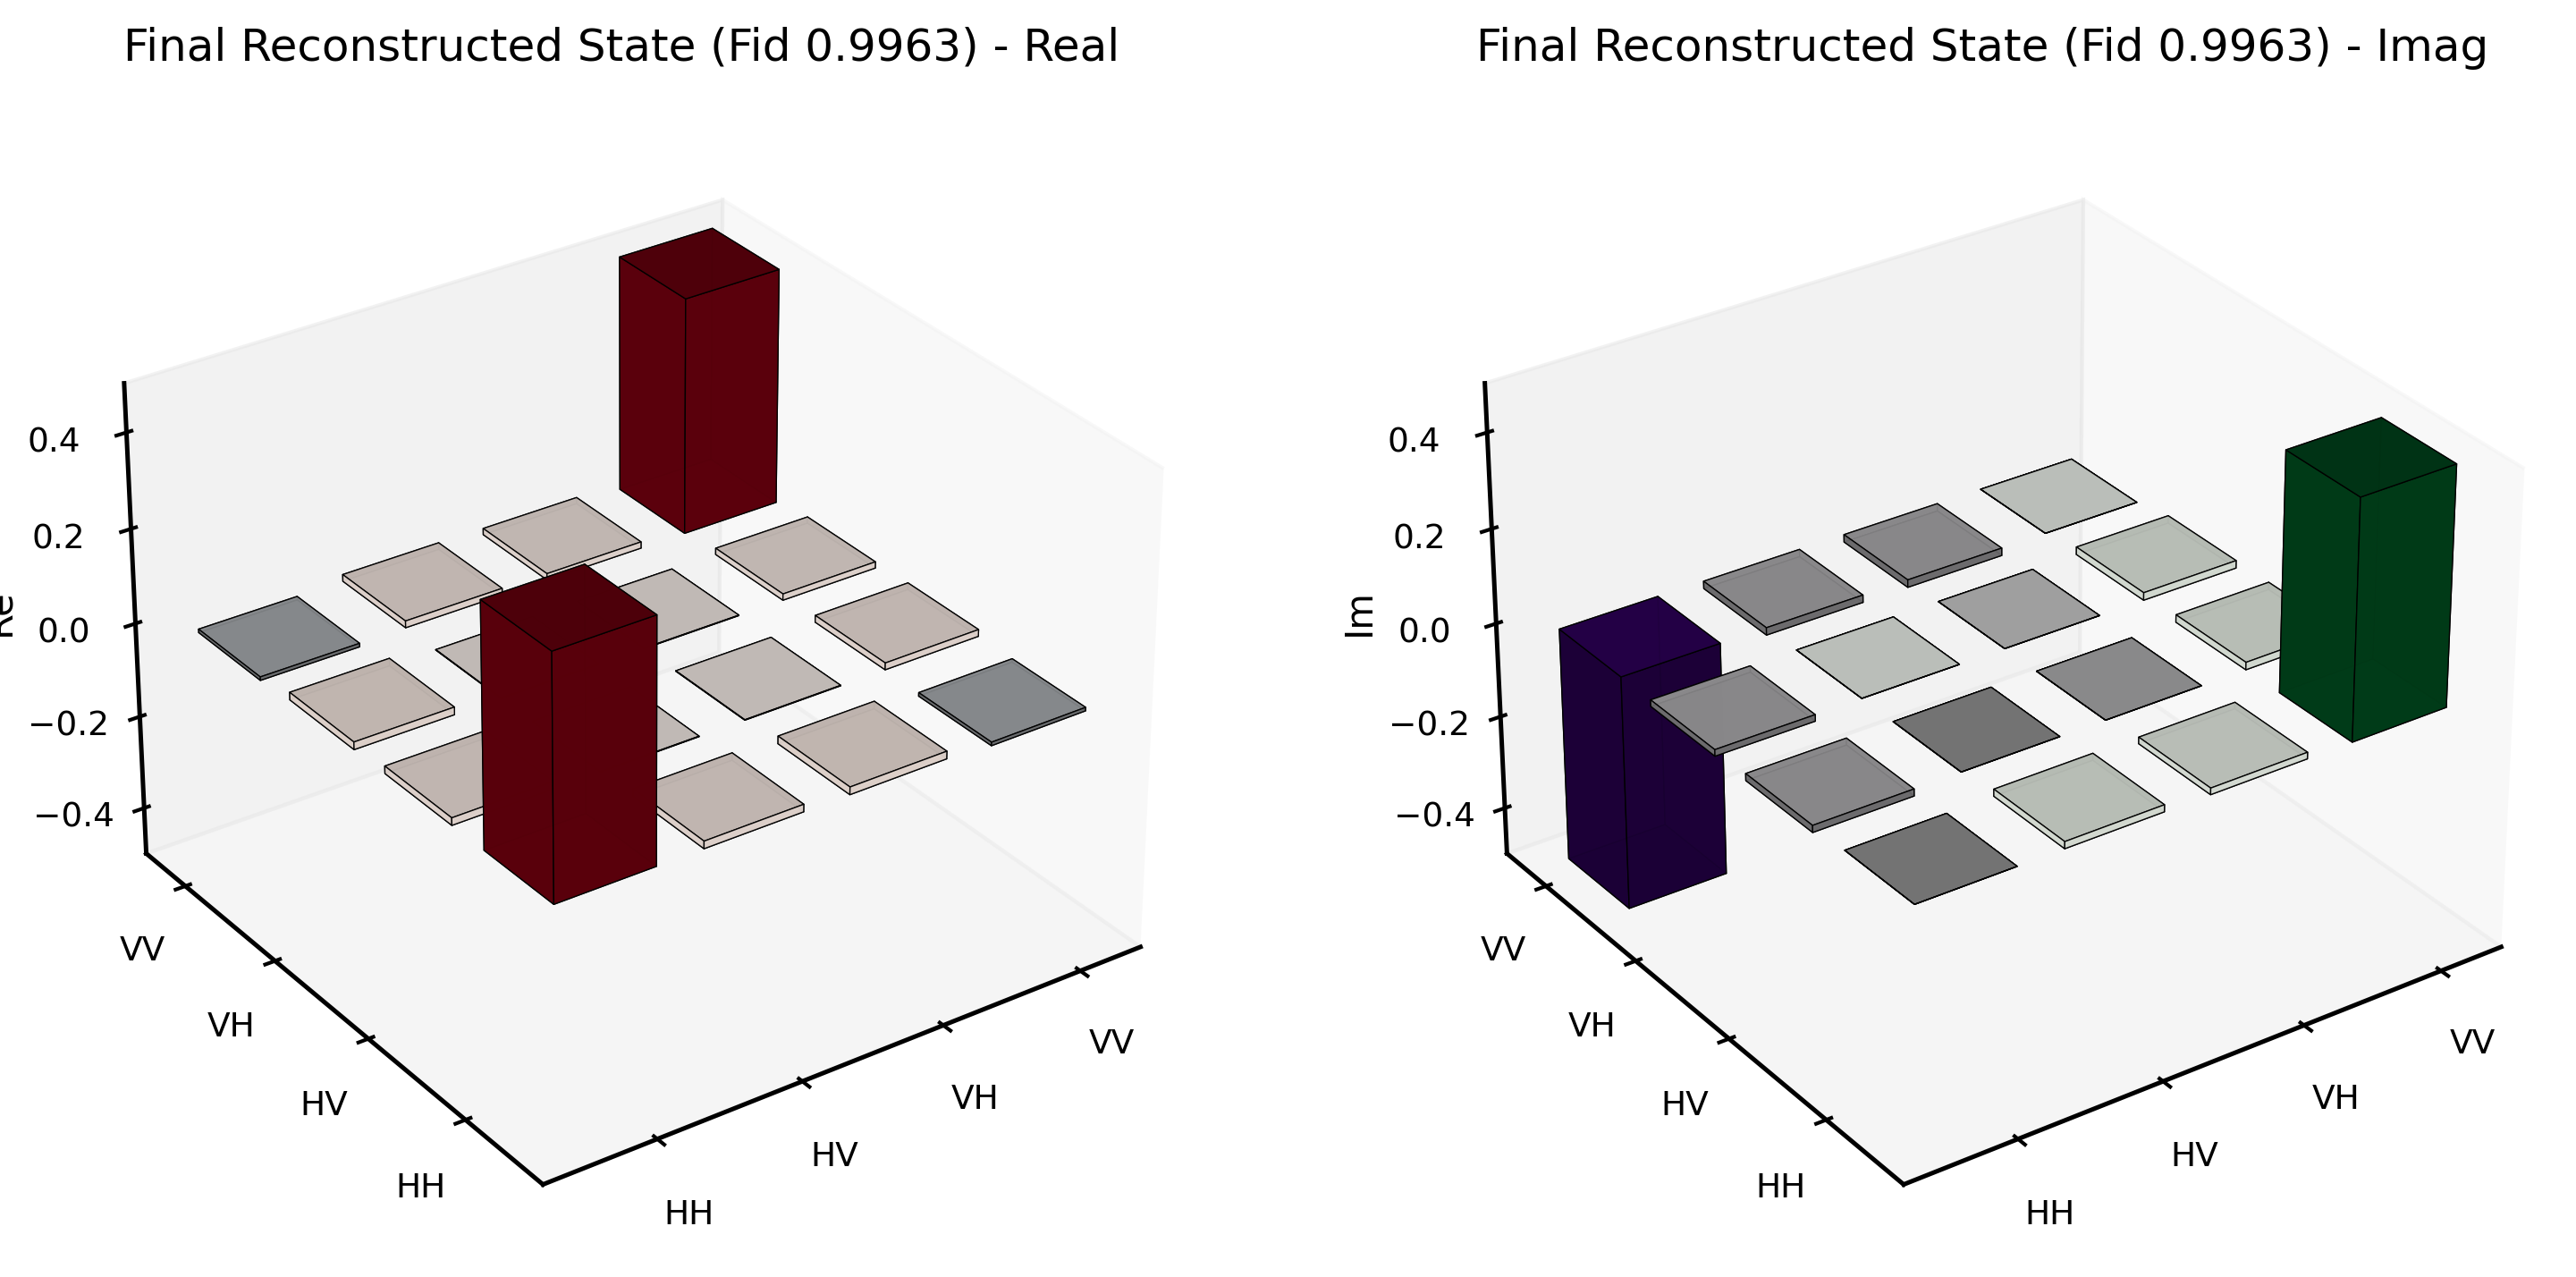

/content/CooperativeNNQST/2qubit/src/visualization.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2.0)


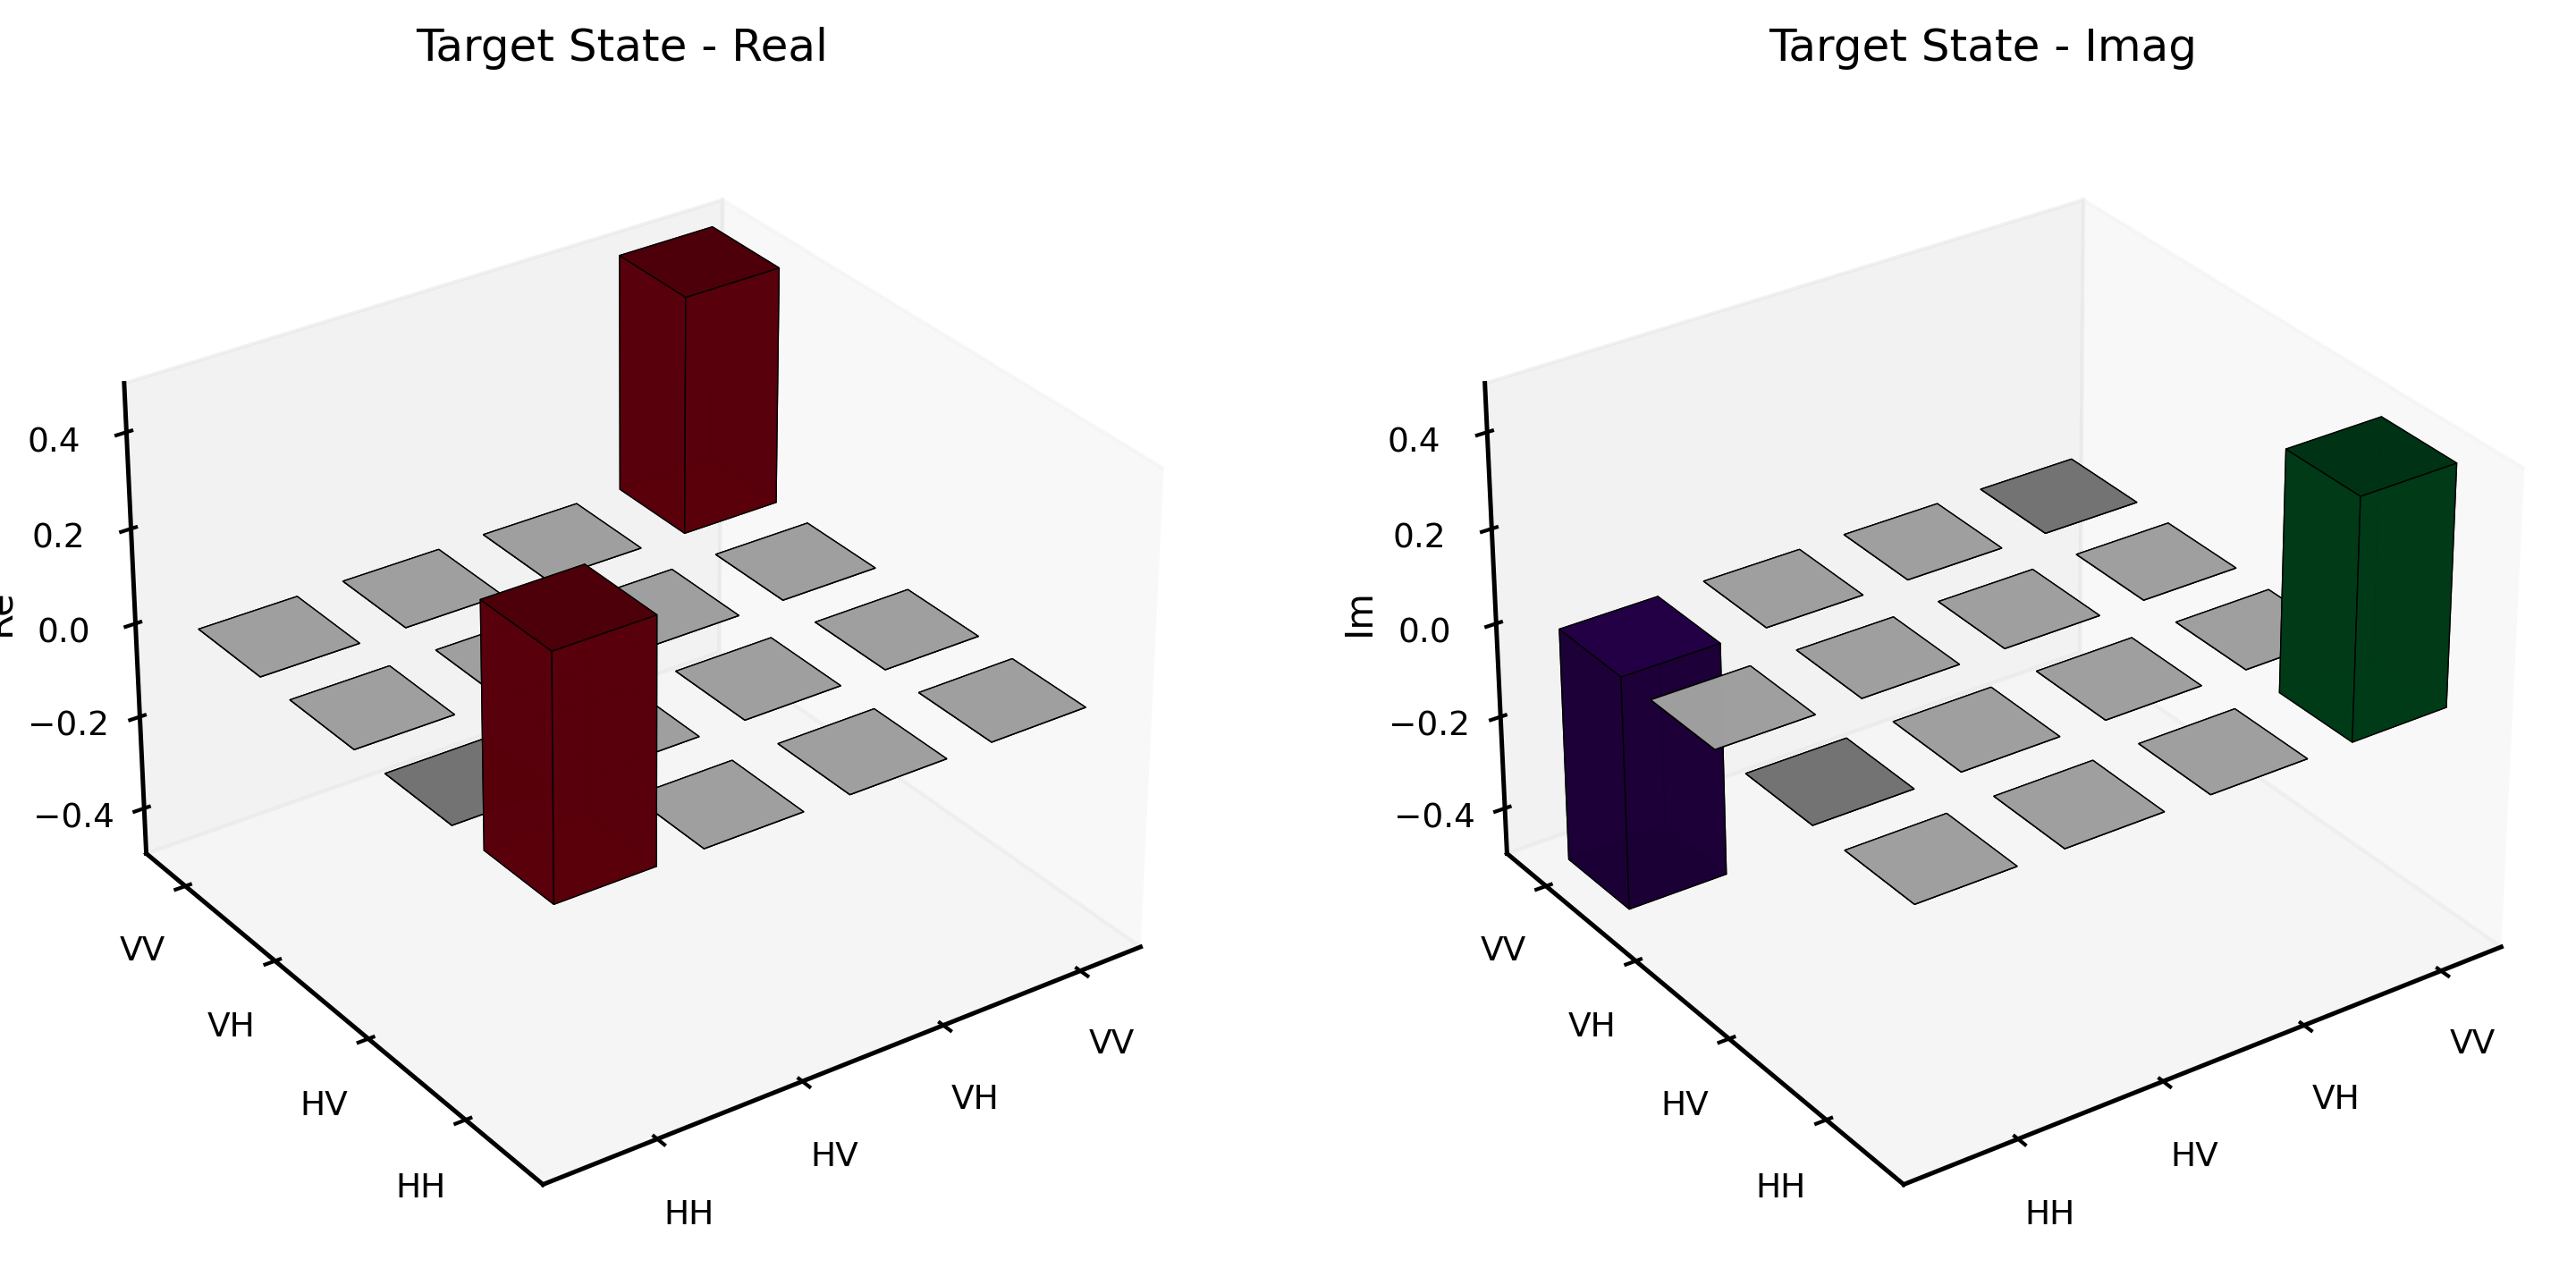

In [8]:
# 3D draw
final_rho = phase_dm_log[-1] if phase_dm_log else amp_dm_log[-1]
final_fid = fidelity(final_rho, target_rho)

print_text(f"\nFinal Fidelity vs Target: {final_fid:.6f}")
qdisplay(final_rho, n_qubits=n_qubits, title_prefix=f"Final Reconstructed State (Fid {final_fid:.4f})")
qdisplay(target_rho, n_qubits=n_qubits, title_prefix="Target State")


In [ ]:
# animation of QST evolution
qanimation(
    amp_dm_hist=amp_dm_log,
    phase_dm_hist=phase_dm_log,
    ideal_rho=target_rho,
    n_qubits=n_qubits,
    output_filepath="figures/qrbm_training_animation.gif"
)
